Synchronization
===============

In this tutorial we will demonstrate how to synchronize two Qblox instruments using the SYNQ technology (see section 
[Synchronization](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/tutorials/q1asm_tutorials/synchronization.html)).
For this tutorial we will use one QCM and one QRM and we will be acquiring waveforms sequenced by the QCM using the QRM. 
By synchronizing the two instruments using the SYNQ technology, timing the acquisition of the waveforms becomes trivial.

If we are using a QCM and QRM we need to connect both instruments to the same network, connect the $\text{REF}^{out}$ of the QCM to the 
$\text{REF}^{in}$ of the QRM using a 50cm coaxial cable, connect their SYNQ ports using the SYNQ cable and finally connect $\text{O}^{[1-2]}$ of the QCM to $\text{I}^{[1-2]}$ of the QRM respectively.

The Cluster QCM and QRM are internally connected for SYNQ capability and therefore no new need connections need to be made if one is using a Cluster.

To run this tutorial please make sure you have installed and enabled ipywidgets: 
```
pip install ipywidgets
jupyter nbextension enable --py widgetsnbextension
```

Setup
-----

First, we are going to import the required packages and connect to the instrument.

In [1]:
# Import ipython widgets
import json
import math
import os

import ipywidgets as widgets
import matplotlib.pyplot as plt     
import numpy as np

# Set up the environment.
import scipy.signal
from IPython.display import display
from ipywidgets import fixed, interact, interact_manual, interactive
from qcodes import Instrument
from qblox_instruments import Cluster, PlugAndPlay

### Scan For Devices

We scan for the available devices connected via ethernet using the Plug & Play functionality of the Qblox Instruments package (see [Plug & Play](https://qblox-qblox-instruments.readthedocs-hosted.com/en/master/api_reference/pnp.html) for more info).

In [2]:
# Scan for available devices and display
with PlugAndPlay() as p:
    # get info of all devices
    device_list = p.list_devices()
    
names = {
    dev_id: dev_info["description"]["name"] for dev_id, dev_info in device_list.items()
}
ip_addresses = {
    dev_id: dev_info["identity"]["ip"] for dev_id, dev_info in device_list.items()
}

# create widget for names and ip addresses
connect = widgets.Dropdown(
    options=[(names[dev_id] + " @" + ip_addresses[dev_id], dev_id) 
             for dev_id in device_list.keys()],
    description="Select Device",
)
display(connect)

Dropdown(description='Select Device', options=(('cluster-mm @10.10.200.69', '00015_2206_003'), ('QAE-cluster @…

### Connect to Cluster

We now make a connection with the Cluster selected in the dropdown widget. We also define a function to find the modules we're interested in. We select the readout and control module we want to use.

In [ ]:
# Connect to device
dev_id = connect.value
# Close the chosen QCodes instrument as to prevent name clash.
try:
    Instrument.find_instrument(names[dev_id]).close()
except KeyError:
    pass

cluster = Cluster(name=names[dev_id], identifier=ip_addresses[dev_id], debug=True) # TODO remove debug

print(f"{connect.label} connected")
print(cluster.get_system_state())

In [ ]:
def select_module_widget(device, select_all=False, select_qrm_type: bool=True, select_rf_type: bool=False):
    """Create a widget to select modules of a certain type
    
    default is to show only QRM baseband

    Args:
        devices : Cluster we are currently using
        select_all (bool): ignore filters and show all modules
        select_qrm_type (bool): filter QRM/QCM
        select_rf_type (bool): filter RF/baseband
    """
    options = [[None, None]]


    for module in device.modules:
        if module.present():
            if select_all or (module.is_qrm_type == select_qrm_type and module.is_rf_type == select_rf_type):
                options.append(
                    [
                        f"{device.name} "
                        f"{module.short_name} "
                        f"({module.module_type}{'_RF' if module.is_rf_type else ''})",
                        module,
                    ]
                )
    widget = widgets.Dropdown(options=options)
    display(widget)

    return widget

In [ ]:
print("Select the readout module from the available modules:")
select_readout_module = select_module_widget(cluster, select_qrm_type=True, select_rf_type=False)

In [ ]:
readout_module = select_readout_module.value
print(f"{readout_module} connected")

In [ ]:
print("Select the control module from the available modules:")
select_control_module = select_module_widget(cluster, select_qrm_type=False, select_rf_type=False)

In [ ]:
control_module = select_control_module.value
print(f"{control_module} connected")

### Reset the Cluster

We reset the Cluster to enter a well-defined state. Note that resetting will clear all stored parameters, so resetting between experiments is usually not desirable.

In [ ]:
cluster.reset()
print(cluster.get_system_state())

Generate waveforms<a id='gen_wf'></a>
------------------

Next, we need to create the waveforms for the sequence.

In [6]:
# Waveform parameters
waveform_length = 120  # nanoseconds

# Waveform dictionary (data will hold the samples and index will be used to select the waveforms in the instrument).
waveforms = {
    "gaussian": {
        "data": scipy.signal.windows.gaussian(
            waveform_length, std=0.12 * waveform_length
        ).tolist(),
        "index": 0,
    },
    "sine": {
        "data": [
            math.sin((2 * math.pi / waveform_length) * i)
            for i in range(0, waveform_length)
        ],
        "index": 1,
    },
}

Let's plot the waveforms to see what we have created.

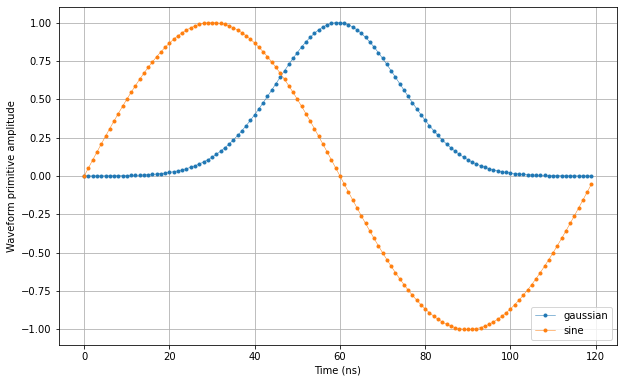

In [7]:
time = np.arange(0, max(map(lambda d: len(d["data"]), waveforms.values())), 1)
fig, ax = plt.subplots(1, 1, figsize=(10, 10 / 1.61))

for wf, d in waveforms.items():
    ax.plot(time[: len(d["data"])], d["data"], ".-", linewidth=0.5, label=wf)

ax.legend(loc=4)
ax.grid(alpha = 1/10)
ax.set_ylabel("Waveform primitive amplitude")
ax.set_xlabel("Time (ns)")

plt.draw()
plt.show()

Specify acquisitions
--------------------

We also need to specify the acquisitions so that the instrument can allocate the required memory for it's acquisition list. In this case we will create one acquisition specification that creates a single bin. However, we will not be using the bin in this tutorial.

In [8]:
# Acquisitions
acquisitions = {"measurement": {"num_bins": 1, "index": 0}}

Create Q1ASM programs
---------------------

Now that we have the waveforms and acquisition specifications for the sequence, we need a simple Q1ASM program that sequences the waveforms in the QCM and
acquires the waveforms in the QRM.

In [9]:
# QCM sequence program.
qcm_seq_prog = """
wait_sync 4         #Synchronize sequencers over multiple instruments.
play      0,1,16384 #Play waveforms and wait remaining duration of scope acquisition.
stop                #Stop.
"""

# QRM sequence program.
qrm_seq_prog = """
wait_sync 4         #Synchronize sequencers over multiple instruments.
acquire   0,0,16384 #Acquire waveforms and wait remaining duration of scope acquisition.
stop                #Stop.
"""

Upload sequences
----------------

Now that we have the waveforms and Q1ASM programs, we can combine them in the sequences stored in JSON files.

In [10]:
# Add QCM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qcm_seq_prog,
}
with open("qcm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

# Add QRM sequence to single dictionary and write to JSON file.
sequence = {
    "waveforms": waveforms,
    "weights": {},
    "acquisitions": acquisitions,
    "program": qrm_seq_prog,
}
with open("qrm_sequence.json", "w", encoding="utf-8") as file:
    json.dump(sequence, file, indent=4)
    file.close()

Let's write the JSON file to the instruments. We will use sequencer 0 of both QCM and QRM, which will drive outputs $\text{O}^{[1-2]}$
of the QCM and acquire on inputs $\text{I}^{[1-2]}$ of the QRM.

In [11]:
# Upload waveforms and programs to QCM.
control_module.sequencer0.sequence("qcm_sequence.json")

# Upload waveforms and programs to QRM.
readout_module.sequencer0.sequence("qrm_sequence.json")

Play sequences
--------------

The sequence has been uploaded to the instruments. Now we need to configure the sequencers of both the QCM and QRM to use the `wait_sync` instruction
to synchronize and we need to configure the sequencer of the QRM to trigger the acquisition with the `acquire` instruction.
Furthermore we also need to attenuate the QCM's outputs to 40% to be able to capture the full range of the waveforms on the QRM's inputs.

$\text{Attenuation}={Input}/{Output}={2V}/{5V}={0.4}$

In [12]:
# Configure the sequencer of the QCM.
control_module.sequencer0.sync_en(True)
control_module.sequencer0.gain_awg_path0(0.35)  # Adding a bit of margin to the 0.4
control_module.sequencer0.gain_awg_path1(0.35)

# Map sequencer of the QCM to specific outputs (but first disable all sequencer connections)
control_module.disconnect_outputs()
readout_module.disconnect_outputs()
readout_module.disconnect_inputs()

control_module.sequencer0.connect_sequencer("out0_1")

# Also map inputs
readout_module.sequencer0.connect_sequencer("in0_1")

# Configure the scope acquisition of the QRM.
readout_module.scope_acq_sequencer_select(0)
readout_module.scope_acq_trigger_mode_path0("sequencer")
readout_module.scope_acq_trigger_mode_path1("sequencer")

# Configure the sequencer of the QRM.
readout_module.sequencer0.sync_en(True)

Now let's start the sequences.

In [13]:
# Arm and start sequencer of the QCM (only sequencer 0).
control_module.arm_sequencer(0)
control_module.start_sequencer()

# Print status of sequencer of the QCM.
print("QCM status:")
print(control_module.get_sequencer_state(0))
print()

# Arm and start sequencer of the QRM (only sequencer 0).
readout_module.arm_sequencer(0)
readout_module.start_sequencer()

# Print status of sequencer of the QRM.
print("QRM status:")
print(readout_module.get_sequencer_state(0))

QCM status:
Status: Q1_STOPPED, Flags: NONE

QRM status:
Status: STOPPED, Flags: ACQ_SCOPE_DONE_PATH_0, ACQ_SCOPE_DONE_PATH_1, ACQ_BINNING_DONE


Retrieve acquisition
--------------------

The waveforms have now been sequenced on the outputs and acquired on the inputs by both instruments. And as you might have noticed, timing these operations was simplified
significantly by the SYNQ technology. Lets retrieve the resulting data, but first let's make sure the sequencers have finished.

In [14]:
# Wait for the QCM sequencer to stop with a timeout period of one minute.
control_module.get_sequencer_state(0, 1)

# Wait for the QRM acquisition to finish with a timeout period of one minute.
readout_module.get_acquisition_state(0, 1)

# Move acquisition data from temporary memory to acquisition list.
readout_module.store_scope_acquisition(0, "measurement")

# Get acquisition list from instrument.
acq = readout_module.get_acquisitions(0)

Let's plot the result.

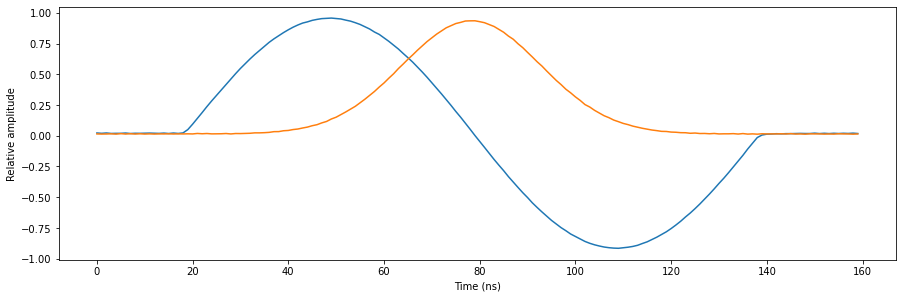

In [15]:
# Plot acquired signal on both inputs.
fig, ax = plt.subplots(1, 1, figsize=(15, 15 / 2 / 1.61))
ax.plot(acq["measurement"]["acquisition"]["scope"]["path0"]["data"][130:290])
ax.plot(acq["measurement"]["acquisition"]["scope"]["path1"]["data"][130:290])
ax.set_xlabel("Time (ns)")
ax.set_ylabel("Relative amplitude")
plt.show()

Stop
----

Finally, let's stop the sequencers if they haven't already and close the instrument connection. One can also display a detailed snapshot containing the instrument parameters before 
closing the connection by uncommenting the corresponding lines. 

In [ ]:
# Stop sequencers.
control_module.stop_sequencer()
readout_module.stop_sequencer()

# Print status of sequencers.
print("QCM:")
print(control_module.get_sequencer_state(0))
print()

print("QRM:")
print(readout_module.get_sequencer_state(0))
print()

# Uncomment the following to print an overview of the instrument parameters.
# Print an overview of instrument parameters.
# print("QCM snapshot:")
# qcm.print_readable_snapshot(update=True)
# print()

# print("QRM snapshot:")
# readout_module.print_readable_snapshot(update=True)

# Close all QCoDeS Instrument instances.
Instrument.close_all()